# Kalman Filter
In this exercise, we will develop the Kalman Filter (KF) for the one-dimensional case and explore the key functions. 

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
#import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ipywidgets import interactive
from scipy.stats import multivariate_normal

from StateSpaceDisplay import state_space_display, state_space_display_updated

pylab.rcParams['figure.figsize'] = 10, 10

In [2]:
pylab.rcParams['figure.figsize'] = 14, 14

For simplicity, the drone that can only move in the vertical direction and the state is the vertical position and velocity $x=(\dot{z}, z)$. The control input for the drone is the vertical acceleration $u = \ddot{z}$. The KF additionally has measurement error associated with the measurements.

The KF will require two type of uncertainty characteristics:

* measurement - the accuracy of the sensor
* motion - drone's ability to precisely execute a given command

The transition function has the following form:

$$
g(x_t,u_t,\Delta t) = \begin{bmatrix} 1 & 0 \\ \Delta t & 1 \end{bmatrix} \begin{bmatrix} \dot{z}\\z \end{bmatrix} + \begin{bmatrix} \Delta t \\ 0 \end{bmatrix} \begin{bmatrix} \ddot{z} \end{bmatrix}  = A_t \mu_{t-1}+B_tu_t
$$

The partial derivative of the $g$ relative to each component is:

$$
g'(x_t,u_t,\Delta t) = \begin{bmatrix} 1 & 0 \\ \Delta t & 1   \end{bmatrix}
$$

$A$ and $B$ matrices, in general, depend on the external parameters we declare them as the separate functions.

In [17]:
class KF:
    def __init__(self,
                 sensor_sigma,             # Sensor noise
                 velocity_sigma,           # Velocity uncertainty
                 position_sigma,           # Position uncertainty
                 dt                        # dt time between samples 
                ):
        
        # Sensor measurement covariance
        self.r_t = np.array([[sensor_sigma**2]])
        
        # Motion model noise for velocity and position
        self.q_t = np.array([[velocity_sigma**2,0.0],
                             [0.0,position_sigma**2]]) 
        self.dt = dt
        
        self.mu = np.array([0.0])
        self.sigma = np.array([0.0])
        
        self.mu_bar = self.mu
        self.sigma_bar = self.sigma

    @property
    def a(self):
        return np.array([[1.0, 0.0],
                         [self.dt, 1.0]])

    @property
    def b(self):
        return np.array([[self.dt],
                         [0.0]])

    def g(self, 
          previous_mu, # Previous mu
          u            # Control input \ddot{z}
          ):
        '''Generates the transition function for the height. '''
        
        return self.a @ previous_mu + self.b * u

    def g_prime(self):
        '''The derivative of the transition function.'''
        # TODO: return the derivative of the g matrix
        return np.array([[1.0, 0.0],
                         [self.dt, 1.0]])


    def initial_values(self, 
                       mu_0, 
                       sigma_0):

        '''Setting initial values for the mu and sigma of the KF'''

        self.mu = mu_0
        self.sigma = sigma_0



    def predict(self, 
                u             # Control input 
               ):

        '''Prediction step of the KF filter '''

        # TODO: Follow the prediction steps outlined in theoretical part of the lesson and implement the next variables. 
        mu_bar = self.g(self.mu, u)
        g_now = self.g_prime()
        sigma_bar = g_now @ (self.sigma @ g_now.T) + self.q_t

        self.mu_bar = mu_bar
        self.sigma_bar = sigma_bar

        return mu_bar, sigma_bar


The KF predicts the next state based on the previous state and the motion the drone undertook since then.

Based on the previous mean and covariance values of the altitude we can predict the new mean and covariance values and estimate the current state. 

In [18]:
z = 0.0                         # Initial position
v = 1.0                         # Initial velocity
dt = 1.0                        # The time difference between measures
sensor_error = 0.1              # Sensor sigma
velocity_sigma = 0.1            # Velocity uncertainty
position_sigma = 0.1            # Position uncertainty


mu_0 = np.array([[v],
                 [z]]) 

sigma_0 = np.array([[velocity_sigma**2, 0.0],
                    [0.0, position_sigma**2]])

u = np.array([[0.0],
              [0.0]])     # no control input is given \ddot{z} = 0 

The entire predict step is declaring the object, initializing and calling the prediction function.w

In [19]:
# Initialize the object
MYKF = KF(sensor_error, velocity_sigma, position_sigma, dt)

# Input the initial values 
MYKF.initial_values(mu_0, sigma_0)

# Call the predict function
mu_bar, sigma_bar = MYKF.predict(u)

print('mu_bar = \n', mu_bar)
print('sigma_bar = \n', sigma_bar)

mu_bar = 
 [[ 1.]
 [ 1.]]
sigma_bar = 
 [[ 0.02  0.01]
 [ 0.01  0.03]]


Plotting the initial and predicted configuration spaces.


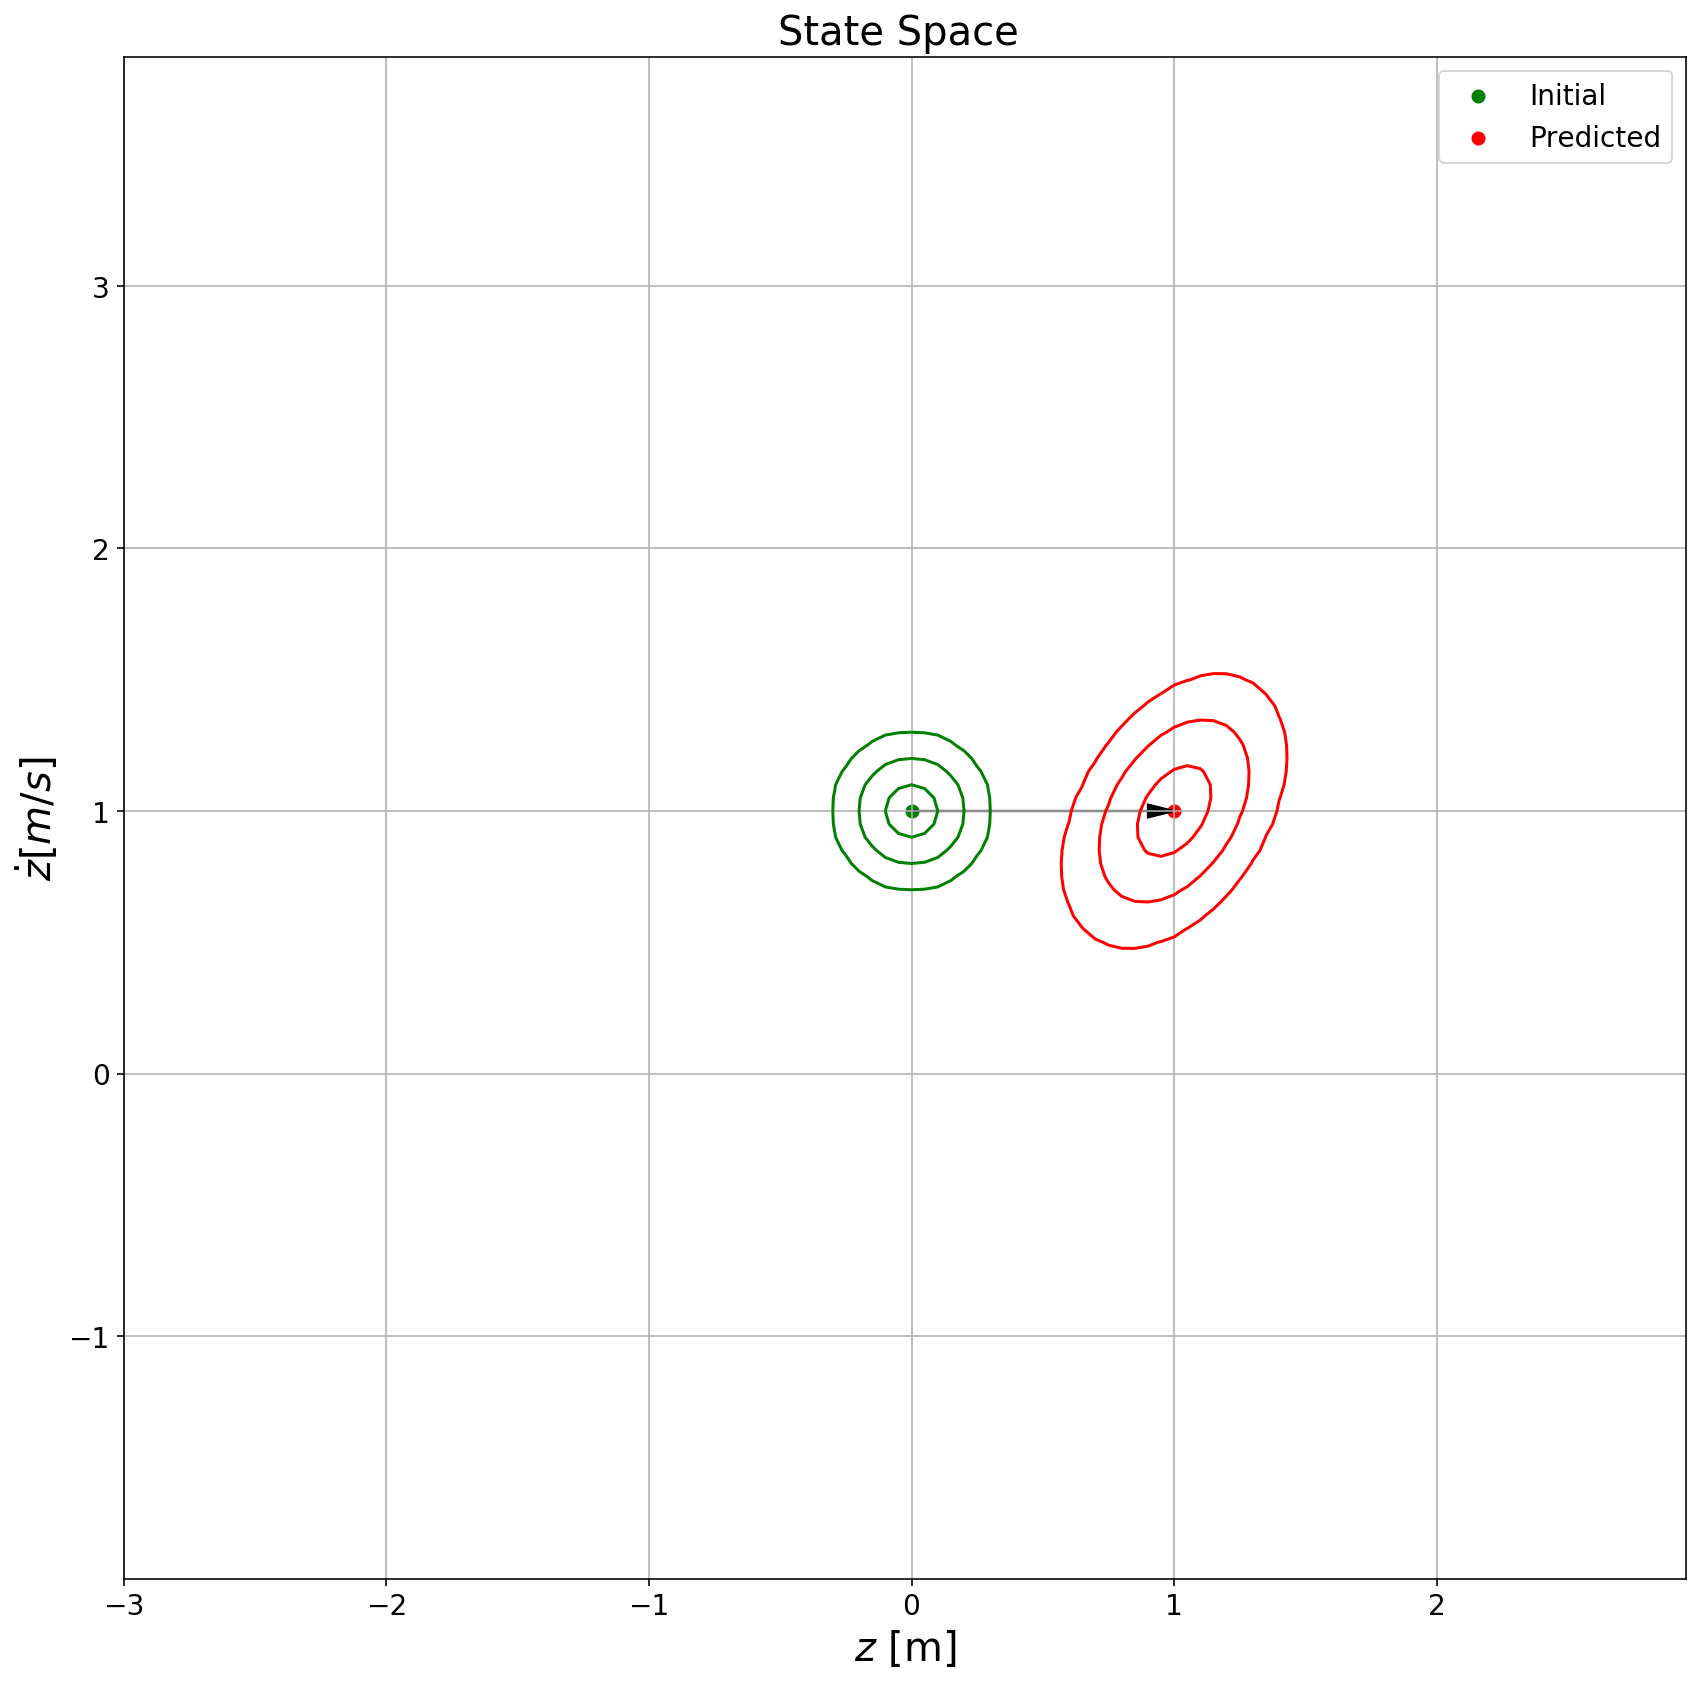

In [20]:
state_space_display(z, v, mu_0, sigma_0, mu_bar, sigma_bar)

### Update the measurement

In this section, we will update the state vector mean position and the covariance based on the measurement that we perform after executing the move. 

$$
h= \begin{bmatrix} 0 & 1  \end{bmatrix} \times \begin{bmatrix}\dot{z} \\ z  \end{bmatrix}
$$

Thus 
$$
h' = \begin{bmatrix} 0 & 1 \end{bmatrix}
$$

In [27]:
%%add_to KF

def h_prime(self):
    return np.array([[0.0, 1.0]])
    
def h(self,mu):
    return np.matmul(np.array([[0.0, 1.0]]), mu) 

def update(self, z):
    inv = np.linalg.inv
    
    # TODO: Follow the update step outlined in theoretical part of the lesson and implement the next variables. 
    H = self.h_prime() 
    K = self.sigma_bar @ H.T @ inv(H @ (self.sigma_bar @ H.T) + self.r_t)
    
    mu = self.mu_bar + K * (z - self.h(self.mu_bar))
    sigma = (np.identity(2) - K @ H) @ self.sigma_bar
    
    self.mu = mu
    self.sigma = sigma
    
    return mu, sigma
    

We'll introduce a single measurement close to the predicted position and update the drones estimated position.

In [28]:
measure = 1.01 # only measuring the Z coordinate

mu_updated, sigma_updated = MYKF.update(measure)

print('updated mean = \n', mu_updated)
print('updated sigma = \n', sigma_updated)

updated mean = 
 [[ 1.0025]
 [ 1.0075]]
updated sigma = 
 [[ 0.0175  0.0025]
 [ 0.0025  0.0075]]


Plotting the state space after update step.

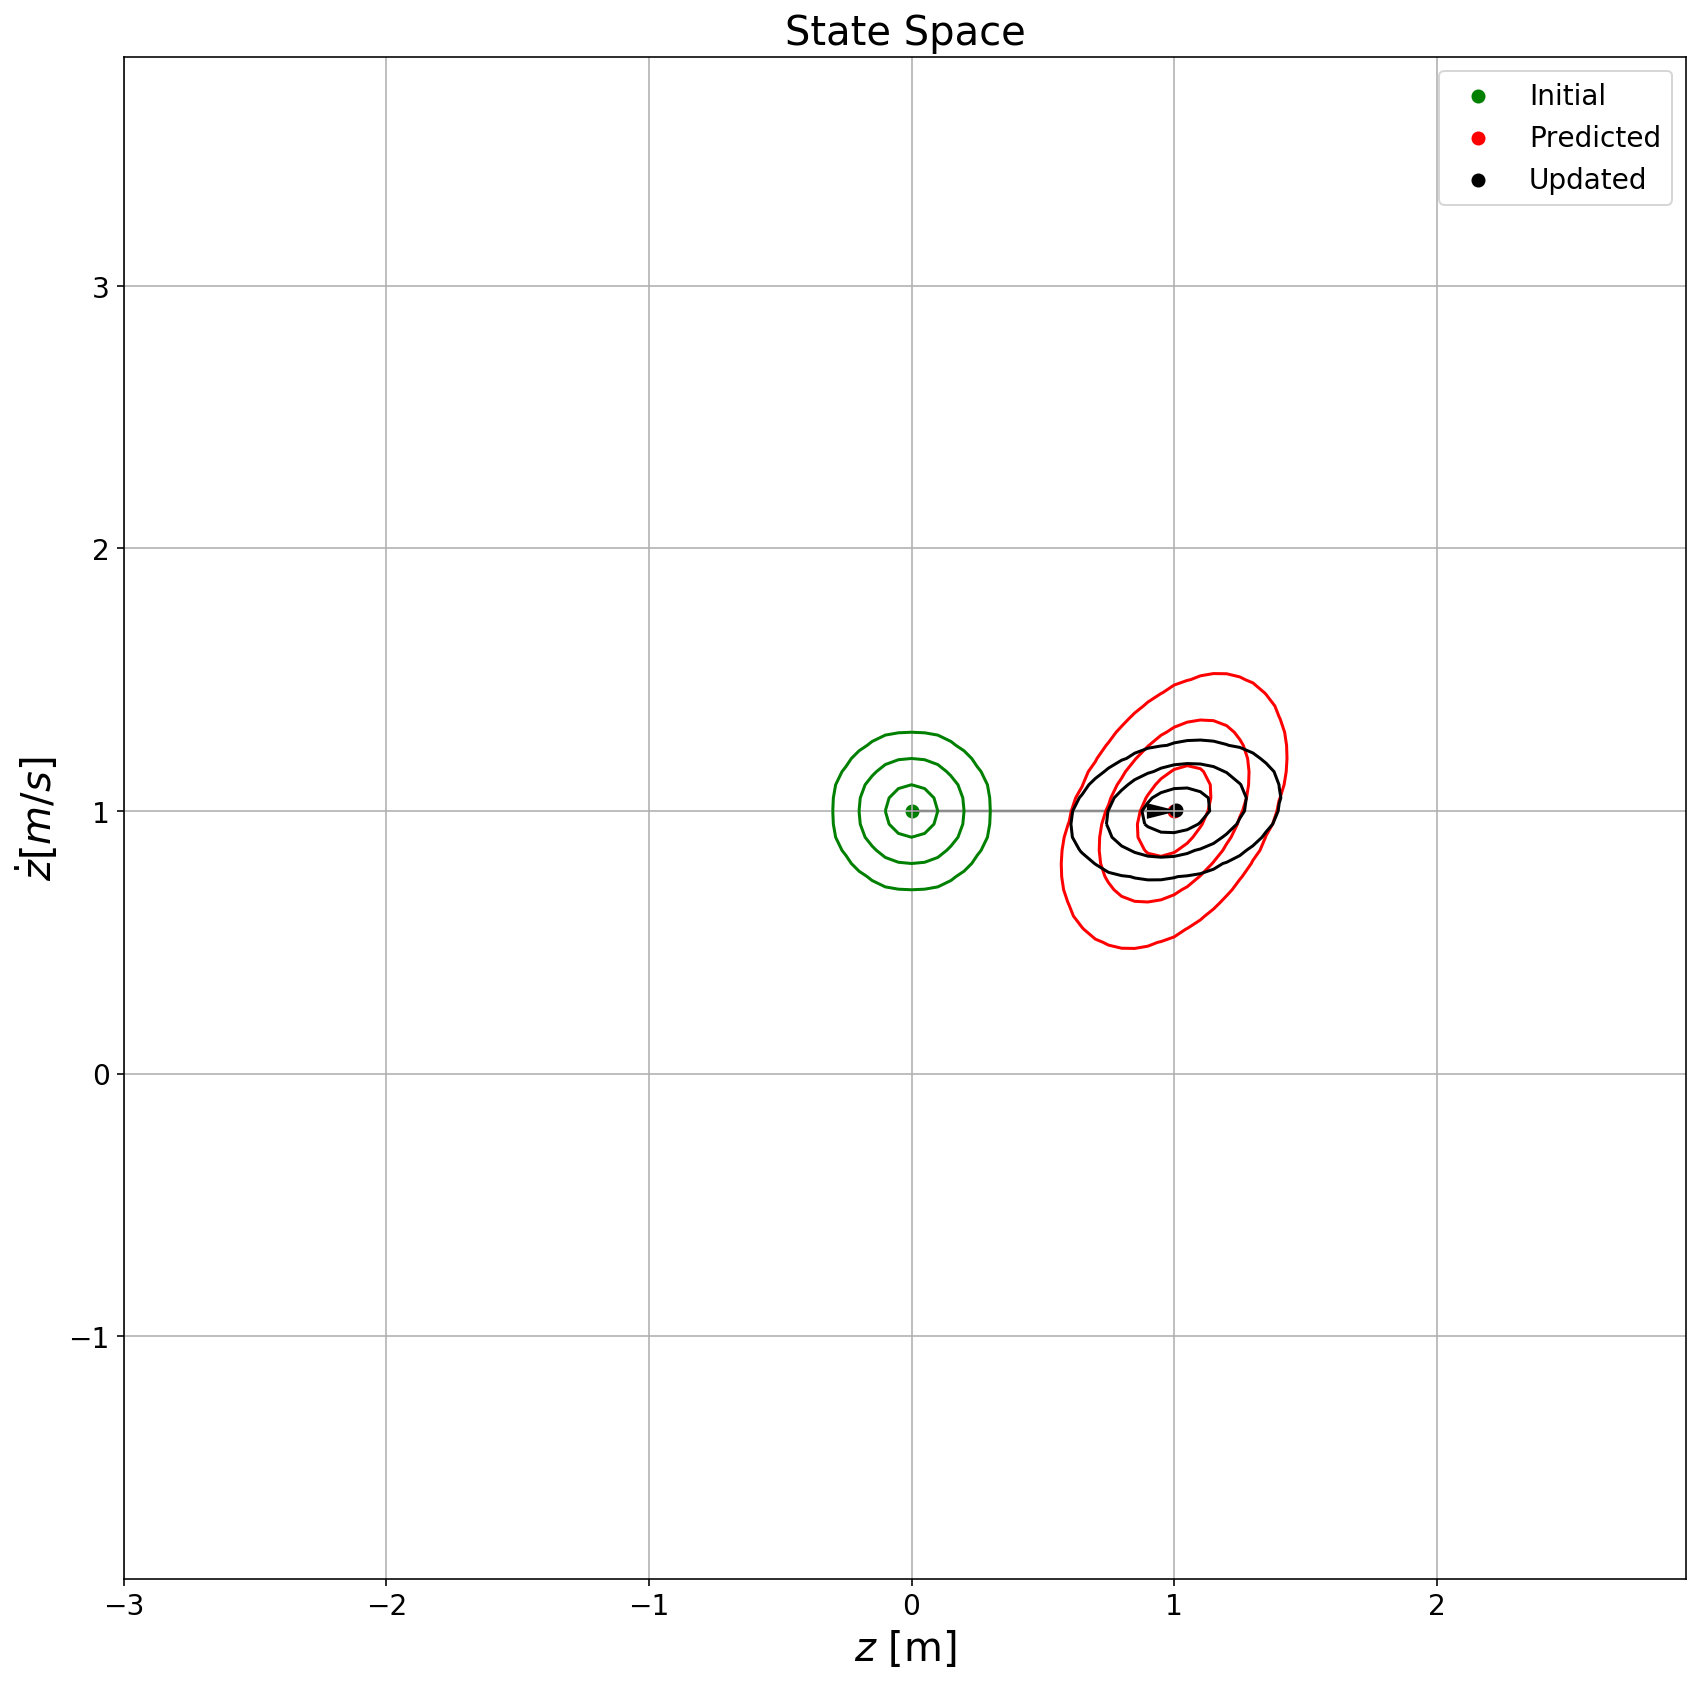

In [29]:
state_space_display_updated(z, v, mu_0, sigma_0, mu_bar, sigma_bar, mu_updated, sigma_updated)

Please note that if you have peformed all operations correctly the updated state should be better defined than the initial state and the predicted state. (the circles should occupy the smaller area.)

### EKF + PID

In this section, the drone is controlled using the altitude obtained by EKF filter instead of averaging as we did in the previous exercise.

In [30]:
from CoaxialDrone import CoaxialCopter
from PIDcontroller import PIDController_with_ff
from PathGeneration import flight_path

First, we will generate the flight path which is constant height of 1m. 

In [31]:
total_time = 10.0  # Total flight time
dt = 0.01          # Time intervale between measurements 

t, z_path, z_dot_path, z_dot_dot_path =  flight_path(total_time, dt,'constant' )

###  IMU

For this section, we will use a simple IMU which only adds noise to the actual altitude measurements.

In [32]:
class IMU:
    def __init__(self):
        pass
        
    def measure(self, z, sigma=0.001): 
        return z + np.random.normal(0.0, sigma)

In [33]:
from DronewithPIDControllerKF import DronewithPIDKF

In [34]:
sensor_error  = 0.1
velocity_sigma = 0.1
position_sigma = 0.1 
MYKF = KF(sensor_error, velocity_sigma, position_sigma, dt)

Let's compare the altitude of the drone when controller only relied on the direct measurements to the case when controller received the estimated altitude from the KF filter. 

In [35]:
# Initializing the drone with PID controller and providing information of the desired flight path. 
FlyingDrone = DronewithPIDKF(z_path, z_dot_path, z_dot_dot_path, t, dt, IMU, KF)

In [36]:
interactive_plot = interactive(FlyingDrone.PID_controler_with_KF, 
                               position_sigma = (0.0, 0.1, 0.001),
                               motion_sigma = (0.0, 0.1, 0.001))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(FloatSlider(value=0.05, description='position_sigma', max=0.1, step=0.001), FloatSlider(value=0.05, description='motion_sigma', max=0.1, step=0.001), Checkbox(value=False, description='use_kf'), Output(layout=Layout(height='800px'))), _dom_classes=('widget-interact',))

This section will allow you to test the different PID controller parameters and compare flight path when using the direct measurement and the KF estimated value to control the drone. 

In [37]:
from DronewithPIDControllerKF import DronewithPIDKFKnobs

In [38]:
FlyingDroneKnobs = DronewithPIDKFKnobs(z_path, z_dot_path, z_dot_dot_path, t, dt, IMU, KF)

In [39]:
interactive_plot = interactive(FlyingDroneKnobs.PID_controler_with_KF_knobs,
                               k_p=(5.0, 35.0, 1),
                               k_d=(0.0, 10, 0.5), 
                               k_i=(0.0, 10, 0.5), 
                               mass_err =(0.7, 1.31, 0.01),
                               sigma = (0.0, 0.1, 0.001),
                               position_sigma = (0.0, 0.1, 0.001),
                               motion_sigma = (0.0, 0.1, 0.001))

output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(FloatSlider(value=20.0, description='k_p', max=35.0, min=5.0, step=1.0), FloatSlider(value=5.0, description='k_d', max=10.0, step=0.5), FloatSlider(value=5.0, description='k_i', max=10.0, step=0.5), FloatSlider(value=1.0, description='mass_err', max=1.31, min=0.7, step=0.01), FloatSlider(value=0.05, description='position_sigma', max=0.1, step=0.001), FloatSlider(value=0.05, description='motion_sigma', max=0.1, step=0.001), Checkbox(value=False, description='use_kf'), Output(layout=Layout(height='800px'))), _dom_classes=('widget-interact',))